In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install tifffile

#!pip install segmentation-models-pytorch
!pip install -U segmentation-models-pytorch albumentations --user

Requirement already up-to-date: segmentation-models-pytorch in /usr/local/lib/python3.6/dist-packages (0.1.0)
Requirement already up-to-date: albumentations in /root/.local/lib/python3.6/site-packages (0.4.5)


In [0]:
cd /content/drive/My Drive/Projet SatMap/Implementation

/content/drive/My Drive/Projet SatMap/Implementation


In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import bin.data_opening as op
import bin.treatment as tr

import shapely.affinity
import matplotlib.pyplot as plt
import numpy as np

In [0]:
class Dataset(BaseDataset):    
    # Liste des images annotees
    IMAGES  = ('6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2', 
               '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3', '6100_2_2',
               '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0', '6120_2_0', '6120_2_2',
               '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1', '6170_0_4', '6170_2_4',
               '6170_4_1')
    # ID des classes respectives : batiments, routes, arbres, rivieres, lacs 
    CLASSES = ('1', '3', '5', '7', '8')
    
    def __init__(self, classe=None, preprocessing=None, augmentation=None):
        self.classe = self.CLASSES[classe]
        self.preprocessing = preprocessing
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # Ouverture des fichiers
        data_opening = op.DataOpening()

        image, img_size = data_opening.get_tiff(self.IMAGES[i])
        x_max, y_min = data_opening.get_size(self.IMAGES[i])
        train_polygons = data_opening.get_polygons(self.IMAGES[i], self.classe)

        # Traitment des fichiers
        treatment = tr.Treatment()

        x_scaler, y_scaler = treatment.get_scalers(img_size, x_max, y_min)
        list_polygons = shapely.affinity.scale(train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
        mask = treatment.get_mask_polygons(img_size, list_polygons)

        # Modification des images
        image = treatment.get_img_rgb(image).astype('int32')
        mask =  mask[:, :, np.newaxis].astype('float32')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

    def __len__(self):
        return len(self.IMAGES)

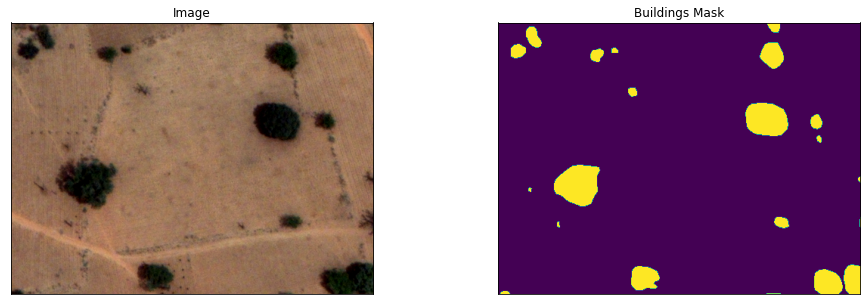

[[[110  82  66]
  [105  79  63]
  [ 99  73  61]
  ...
  [144 108  90]
  [137 103  87]
  [139 109  92]]

 [[100  76  61]
  [104  78  63]
  [111  82  69]
  ...
  [136 102  85]
  [119  88  74]
  [120  93  79]]

 [[106  82  69]
  [108  81  69]
  [120  91  79]
  ...
  [129  97  77]
  [110  78  66]
  [100  73  61]]

 ...

 [[ 46  30  26]
  [ 35  19  18]
  [ 24  10  10]
  ...
  [ 15  27   7]
  [ 21  31   7]
  [ 28  37  13]]

 [[ 37  18  15]
  [ 27   9   7]
  [ 17   1   0]
  ...
  [ 33  43  23]
  [ 36  45  21]
  [ 37  45  21]]

 [[ 28   6   5]
  [ 20   3   0]
  [ 17   0   0]
  ...
  [ 47  54  31]
  [ 40  46  26]
  [ 35  39  18]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  ...
  [1.]
  [1.]
  [1.]]]


In [0]:
# Lets look at data we have

dataset = Dataset(classe=2)

image, mask = dataset[17] # get some sample

visualize(image=image, buildings_mask=mask.squeeze())

#print(image)
#print(mask)

In [0]:
import albumentations as albu
import torchvision.transforms as transforms

In [0]:
def get_training_augmentation():
    """
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)
    """
    augment_transform = transforms.Compose([
        # Rotation aleatoire de quelques degres (10)
        transforms.RandomRotation(25),
        # Variation des contrastes et des couleurs 
        transforms.ColorJitter(),
        # Flip horizontal aleatoire
        transforms.RandomHorizontalFlip(),
        # Crop aleatoire
        transforms.RandomCrop(10),
    ])

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [0]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(classe=0, augmentation=get_training_augmentation())

# same image with different random transforms
#for i in range(3):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask.squeeze(-1))

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

#model = smp.Unet("se_resnext50_32x4d", encoder_weights="imagenet", classes=1, activation=None)
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn("se_resnext50_32x4d", "imagenet")

In [0]:
train_dataset = Dataset(classe=0, preprocessing=preprocessing_fn, augmentation=get_training_augmentation)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

In [0]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()

metrics = [
           smp.utils.metrics.IoU(threshold=0.5),
           ]

optimizer = torch.optim.Adam([
                              dict(params=model.parameters(), lr=0.0001),
                              ])

In [0]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
DEVICE = 'cuda'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [0]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/4 [00:06<?, ?it/s]


TypeError: ignored